# **Compulsory Assignment 04 - DAT200 - spring2020**
- Fabio Rodrigues Pereira
- Kaggle: @fabiorodp
- NMBU: fabio.rodrigues.pereira@nmbu.no

# =======================================================================
# Import necessaries libraries:
# =======================================================================

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# ======================================================================
# Helper Functions:
# ======================================================================

In [0]:
def evaluate(df_scenarios, clf):
    for e, df in df_scenarios:
        print('\n', e)

        X_train, X_test, y_train, y_test = \
            train_test_split(df.iloc[:, :-1],
                             df.iloc[:, -1],
                             test_size=0.20,
                             stratify=df.iloc[:, -1],
                             random_state=1)

        clf.fit(X_train, y_train)

        y_pred = clf.best_estimator_.predict(X_test)
        confusion_matrix_plot(y_test, y_pred)

        bal_acc = balanced_accuracy_score(y_test, y_pred)
        prec_acc = precision_score(y_test, y_pred, average="macro")
        rc_acc = recall_score(y_test, y_pred, average="macro")
        f1_acc = f1_score(y_test, y_pred, average="macro")

        print("\nBest Score: ", clf.best_score_,
              "\n",
              "\nBalanced Score: ", bal_acc,
              "\n",
              "\nPrecision Score: ", prec_acc,
              "\n",
              "\nRecall Score: ", rc_acc,
              "\n",
              "\nF1 Score: ", f1_acc,
              "\n",
              "\nBest Parameters: ", clf.best_params_)


def confusion_matrix_plot(y_true, y_pred):
    conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)

    labels = ['Class{}'.format(i+1) for i in range(len(conf_mat))]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()
    

def save_csv(df_test, classifier, csv_name):
    df_prediction = pd.DataFrame(
        classifier.predict(df_test.values), columns=["label"])

    df_prediction = pd.concat(
        [df_prediction, pd.DataFrame(
            [i for i in range(len(df_prediction))], columns=["id"])], axis=1)

    df_prediction.to_csv(csv_name, 
                         float_format="%d", 
                         columns=["label", "id"], 
                         index=False)

# ======================================================================
# Read train and test datasets as dataframe:
# ======================================================================

In [0]:
df=pd.read_csv("drive/My Drive/Estudos/V20/DAT200/CA04/glassTrain.csv", 
               index_col="Unnamed: 0")

df_test = pd.read_csv("drive/My Drive/Estudos/V20/DAT200/CA04/glassTest.csv", 
                      index_col="Unnamed: 0")

# =======================================================================
# Check raw data:
# =======================================================================

In [14]:
#Verify data frame dimensions:
print("Train dimension: ", df.shape,
      "\nTest dimension: ", df_test.shape)

Train dimension:  (143, 10) 
Test dimension:  (71, 9)


**Conclusions:**
- The train data is very small with only 143 samples.

In [15]:
# Verify null and duplucated samples:
print("Train Data Frame:", 
      "\n# of null/missing values:", df.isnull().any().sum(),
      "\n# of duplicated samples:", df.duplicated().sum(),
      "\n\nTest Data Frame:",
      "\n# of null/missing values:", df_test.isnull().any().sum(),
      "\n# of duplicated samples:", df_test.duplicated().sum())

Train Data Frame: 
# of null/missing values: 0 
# of duplicated samples: 0 

Test Data Frame: 
# of null/missing values: 0 
# of duplicated samples: 0


**Conclusions:**
- There are not missing values or duplicated samples in df neither in df_test.

In [16]:
# Verify targets sizes:
print(df.groupby("type").size())

type
1    47
2    51
3    11
5     9
6     6
7    19
dtype: int64


**Conclusions:**
- There are 6 very imbalanced target classes and 1 missing class ("4"): Some classes have a scarce number of samples, as class "6" with 6 samples and class "5" with 9 samples. This can be a problem and might not be sufficient when we train our models.

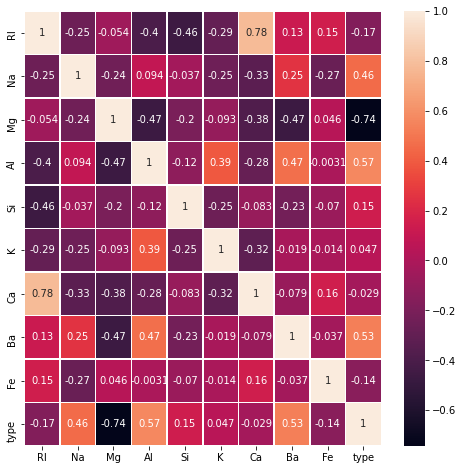

In [17]:
# Check correlations:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df.corr(), annot=True, linewidths=.5, ax=ax)
plt.show()

***Conclusions:***
- 1) "Mg" feature has the **highest (-0,74) negative correlation** with the 
    target;
- 2) Only "Al", "Ba" features have positive (0.57 and 0.53) correlations 
    **larger than 0.5** with the target;
- 3) "RI", "Fe" and "Ca" features have **negative (-0.17, -0.14, -0,029) 
    correlations** with the target;
- 4) "RI" and "Ca" features have the **highest (0.78) correlation between 
    features**;
- 5) No other combination of features has high correcaltion.

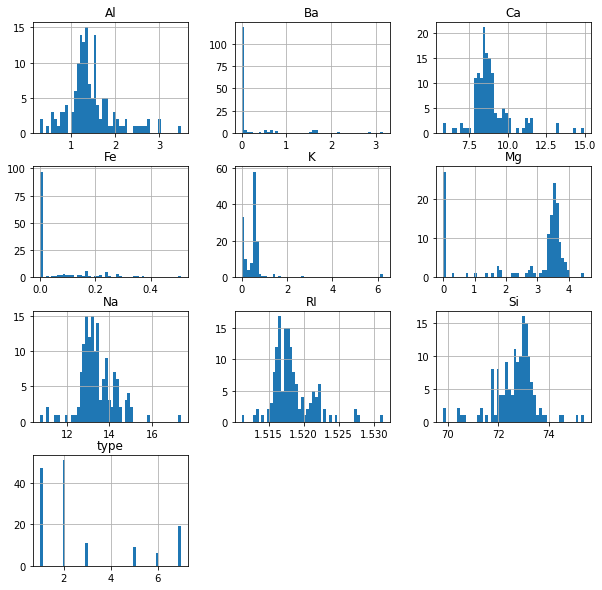

In [18]:
# Check distributions:
df.hist(figsize=(10,10), bins=50)
plt.show()

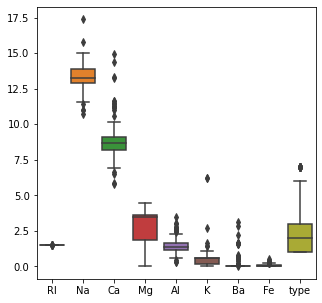

In [19]:
# Check outliers:
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(data=df[["RI", "Na", "Ca", "Mg", "Al", "K", "Ba", "Fe", "type"]], 
            ax=ax)
plt.show()

In [20]:
# Outliers for feature Si:
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(data=df.Si, ax=ax)
plt.show()

***Conclusions:***
- 1) "Mg and "K" features have biased and not symmetrical distribution. 
    These can not be standardised, according to descriptive statistics;
- 2) "Al", "Na", "RI", "Si", "Ca" features have quite symmetrical 
    distributions. These can be standardised, according to descriptive 
    statistics, in order to neutralize outliers;
- 3) "Fe", "Ba" features have many zero values. It might be a good idea to 
    remove them, because too many zero values mean that the features do not 
    have much relevance;
- 4) There are many outliers in each feature. However, it is not feasible 
    to remove all of them, because It will meaningly reduce the data frame 
    size and hide important informations. It might be wiser to try other 
    technniques, like standardisation.

In [21]:
# Descriptive Statistics:
print(df.describe())

               RI          Na          Mg  ...          Ba          Fe        type
count  143.000000  143.000000  143.000000  ...  143.000000  143.000000  143.000000
mean     1.518283   13.407343    2.686014  ...    0.185594    0.058182    2.769231
std      0.002838    0.860110    1.440136  ...    0.535022    0.100853    2.098599
min      1.511150   10.730000    0.000000  ...    0.000000    0.000000    1.000000
25%      1.516550   12.915000    1.855000  ...    0.000000    0.000000    1.000000
50%      1.517680   13.270000    3.480000  ...    0.000000    0.000000    2.000000
75%      1.519100   13.875000    3.610000  ...    0.000000    0.095000    3.000000
max      1.531250   17.380000    4.490000  ...    3.150000    0.510000    7.000000

[8 rows x 10 columns]


# =======================================================================
# Create dataframes with different scenarios:
# df columns: # ["RI", "Fe", "Ca", "Na", "Mg", "Al", "Si", "K", "Ba"]
# =======================================================================

In [0]:
# Drop features with low negative correlations with the target:
df2 = df.drop(["RI", "Fe", "Ca"], axis=1)

# Drop features with many zero values:
df3 = df.drop(["Fe", "Ba"], axis=1)

# Resemble data according to the target classes and balance it:
df4 = pd.DataFrame()

for i in [1, 2, 3, 5, 6, 7]:
    resambled_df = resample(df[df.type == i],
                            replace=True,
                            n_samples=30,
                            random_state=1)

    df4 = pd.concat([df4, resambled_df])

# Scenarios n list:
df_scenarios = [
    ("Scenario 1 - Without any features modification",
     df),
    ("Scenario 2 - Without low and negative correlation features",
     df2),
    ("Scenario 3 - Without many zero value features",
     df3),
    ("Scenario 4 - Resembled and balanced target classes",
     df4)]

# =======================================================================
# SVC + GridSearchCV:
# =======================================================================


 Scenario 1 - Without any features modification
Confusion matrix:
 [[7 2 1 0 0 0]
 [2 7 0 0 1 0]
 [0 1 1 0 0 0]
 [0 0 0 2 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 3]]



Best Score:  0.6758004926108374 
 
Balanced Score:  0.775 
 
Precision Score:  0.6907407407407407 
 
Recall Score:  0.775 
 
F1 Score:  0.7101086048454469 
 
Best Parameters:  {'svc__C': 1000, 'svc__class_weight': None, 'svc__gamma': 0.01, 'svc__kernel': 'rbf', 'svc__random_state': 1}

 Scenario 2 - Without low and negative correlation features
Confusion matrix:
 [[7 1 2 0 0 0]
 [1 7 1 0 1 0]
 [2 0 0 0 0 0]
 [0 0 0 2 0 0]
 [0 0 0 0 1 0]
 [0 1 0 0 0 3]]


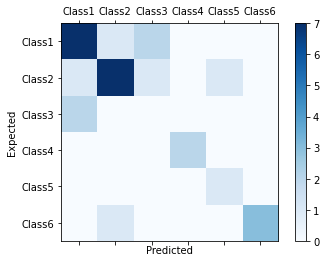


Best Score:  0.6394704433497538 
 
Balanced Score:  0.6916666666666668 
 
Precision Score:  0.662962962962963 
 
Recall Score:  0.6916666666666668 
 
F1 Score:  0.6601086048454469 
 
Best Parameters:  {'svc__C': 100, 'svc__class_weight': None, 'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__random_state': 1}

 Scenario 3 - Without many zero value features
Confusion matrix:
 [[ 7  3  0  0  0  0]
 [ 0 10  0  0  0  0]
 [ 0  0  2  0  0  0]
 [ 0  0  0  2  0  0]
 [ 0  1  0  0  0  0]
 [ 0  2  0  0  0  2]]


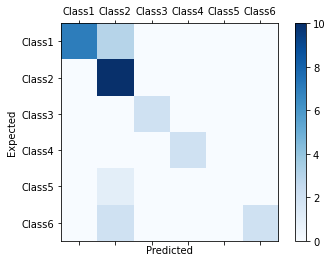

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best Score:  0.7192118226600985 
 
Balanced Score:  0.7000000000000001 
 
Precision Score:  0.7708333333333334 
 
Recall Score:  0.7000000000000001 
 
F1 Score:  0.709904474610357 
 
Best Parameters:  {'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 1, 'svc__kernel': 'rbf', 'svc__random_state': 1}

 Scenario 4 - Resembled and balanced target classes
Confusion matrix:
 [[6 0 0 0 0 0]
 [0 5 1 0 0 0]
 [0 0 6 0 0 0]
 [0 0 0 6 0 0]
 [0 0 0 0 6 0]
 [0 1 0 0 0 5]]


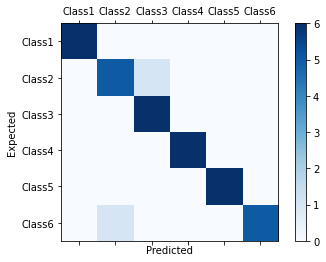


Best Score:  0.8680555555555556 
 
Balanced Score:  0.9444444444444445 
 
Precision Score:  0.9484126984126985 
 
Recall Score:  0.9444444444444445 
 
F1 Score:  0.9442501942501943 
 
Best Parameters:  {'svc__C': 100, 'svc__class_weight': 'balanced', 'svc__gamma': 1, 'svc__kernel': 'rbf', 'svc__random_state': 1}


In [43]:
# C regularisation and gamma on (0.0001:1000:10**i)
# random state on range(1, 160, 20)
param_grid_svc = [
    {"svc__C": [10**i for i in range(-4, 4)],
     "svc__kernel": ["linear"],
     "svc__class_weight": ["balanced", None],
     "svc__random_state": [i for i in range(1, 160, 20)]
     },
    {"svc__C": [10**i for i in range(-4, 4)],
     "svc__gamma": [10**i for i in range(-4, 4)],
     "svc__kernel": ["rbf"],
     "svc__class_weight": ["balanced", None],
     "svc__random_state": [i for i in range(1, 160, 20)]
     }]

gs = GridSearchCV(estimator=make_pipeline(StandardScaler(),
                                          SVC(random_state=1)),
                  param_grid=param_grid_svc,
                  scoring="accuracy",
                  cv=4,
                  n_jobs=-1
                  )

evaluate(df_scenarios, clf=gs)

**Conclusions**: 
- **In Scenario 1 where the dataset had not feature selection**: 
-- **Confulsion Matrix:** Not ideal, because there are predictions on False Positive and False Negative squares;
-- **Best Score:**  0.6758004926108374  
-- **Balanced Score:**  0.775 
-- **Precision Score:**  0.6907407407407407 
-- **Recall Score:**  0.775 
-- **F1 Score:**  0.7101086048454469 
-- **Best Parameters:**  {'svc__C': 1000, 'svc__class_weight': None, 'svc__gamma': 0.01, 'svc__kernel': 'rbf', 'svc__random_state': 1}

- **In Scenario 2 where the dataset had feature selection (Without low and negative correlation features)**: 
-- **Confulsion Matrix:** Not ideal, because there are predictions on False Positive and False Negative squares;
-- **Best Score:**  0.6394704433497538 
-- **Balanced Score:**  0.6916666666666668
-- **Precision Score:**  0.662962962962963 
-- **Recall Score:**  0.6916666666666668 
-- **F1 Score:**  0.6601086048454469 
-- **Best Parameters:** {'svc__C': 100, 'svc__class_weight': None, 'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__random_state': 1}

- **In Scenario 3 where the dataset had feature selection (Without many zero value features)**: 
-- **Confulsion Matrix:** Beter than the previous ones, but still there are predictions on False Positive and False Negative squares;
-- **Best Score:** 0.7192118226600985
-- **Balanced Score:**  0.7000000000000001  
-- **Precision Score:**  0.7708333333333334 
-- **Recall Score:**  0.7000000000000001  
-- **F1 Score:**  0.709904474610357 
-- **Best Parameters:**  {'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 1, 'svc__kernel': 'rbf', 'svc__random_state': 1}

- **In Scenario 4 where the dataset had resembled target classes (Underresembled major classes and oversampled minor classes)**: 
-- **Confulsion Matrix:** The best in this experiment, because there are just a few predictions on False Positive and False Negative squares;
-- **Best Score:**  0.8680555555555556 
-- **Balanced Score:**  0.9444444444444445 
-- **Precision Score:**  0.9484126984126985 
-- **Recall Score:**  0.9444444444444445 
-- **F1 Score:**  0.9442501942501943 
-- **Best Parameters:**  {'svc__C': 100, 'svc__class_weight': 'balanced', 'svc__gamma': 1, 'svc__kernel': 'rbf', 'svc__random_state': 1}


# =======================================================================
# SVC + Feature Dimensions + GridSearchCV:
# =======================================================================


 Scenario 1 - Without any features modification
Confusion matrix:
 [[6 4 0 0 0 0]
 [1 9 0 0 0 0]
 [1 1 0 0 0 0]
 [0 2 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 3]]


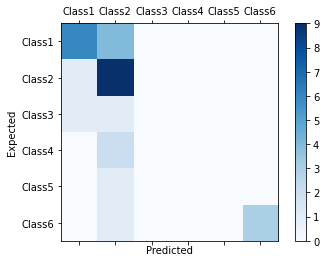

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best Score:  0.631578947368421 
 
Balanced Score:  0.375 
 
Precision Score:  0.375 
 
Recall Score:  0.375 
 
F1 Score:  0.3611111111111111 
 
Best Parameters:  {'classifier__C': 10.0, 'classifier__class_weight': None, 'classifier__gamma': 1.05, 'preprocess__kernelpca__gamma': 1.0, 'preprocess__kernelpca__n_components': 7}

 Scenario 2 - Without low and negative correlation features
Confusion matrix:
 [[9 1 0 0 0 0]
 [2 8 0 0 0 0]
 [2 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 3]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best Score:  0.5789473684210527 
 
Balanced Score:  0.4083333333333334 
 
Precision Score:  0.3846153846153846 
 
Recall Score:  0.4083333333333334 
 
F1 Score:  0.38923395445134573 
 
Best Parameters:  {'classifier__C': 115.0, 'classifier__class_weight': None, 'classifier__gamma': 0.1, 'preprocess__kernelpca__gamma': 1.0, 'preprocess__kernelpca__n_components': 7}

 Scenario 3 - Without many zero value features
Confusion matrix:
 [[7 3 0 0 0 0]
 [1 9 0 0 0 0]
 [0 1 1 0 0 0]
 [0 2 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 3]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best Score:  0.631578947368421 
 
Balanced Score:  0.47500000000000003 
 
Precision Score:  0.5674019607843137 
 
Recall Score:  0.47500000000000003 
 
F1 Score:  0.4947089947089947 
 
Best Parameters:  {'classifier__C': 10.0, 'classifier__class_weight': None, 'classifier__gamma': 1.525, 'preprocess__kernelpca__gamma': 1.0, 'preprocess__kernelpca__n_components': 7}

 Scenario 4 - Resembled and balanced target classes
Confusion matrix:
 [[3 2 0 0 1 0]
 [1 2 0 3 0 0]
 [0 0 6 0 0 0]
 [0 0 0 6 0 0]
 [0 0 0 1 5 0]
 [0 0 0 1 0 5]]


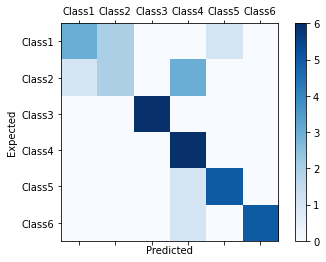


Best Score:  0.7013888888888888 
 
Balanced Score:  0.75 
 
Precision Score:  0.7714646464646465 
 
Recall Score:  0.75 
 
F1 Score:  0.7413844325609031 
 
Best Parameters:  {'classifier__C': 45.0, 'classifier__class_weight': 'balanced', 'classifier__gamma': 1.525, 'preprocess__kernelpca__gamma': 1.0, 'preprocess__kernelpca__n_components': 5}


In [42]:
# Create a combined preprocessing object:
preprocess = FeatureUnion(
    [('kernelpca', KernelPCA(kernel="rbf"))
     #("kbest", SelectKBest())
     ])

# Create a pipeline
pipe = Pipeline(
    [('preprocess', preprocess),
     ('classifier', SVC(kernel='rbf',
                        random_state=1))
     ])

# Create space of candidate values:
search_space = [
    {'preprocess__kernelpca__n_components': [3, 4, 5, 6, 7],
     'preprocess__kernelpca__gamma': np.linspace(1, 15, 5),
     #'preprocess__kbest__k': [3, 4, 5, 6],

     'classifier__C': np.linspace(10, 150, 5),
     'classifier__gamma': np.linspace(0.1, 2, 5),
     'classifier__class_weight': ["balanced", None]
     }]

# Create grid search:
clf = GridSearchCV(pipe,
                   search_space,
                   cv=2,
                   n_jobs=-1)

evaluate(df_scenarios, clf=clf)

**Conclusions:**
- **In Scenario 1 where the dataset had not feature selection but feature dimension modified**: 
-- **Confulsion Matrix:** Very bad, because there are way too many predictions on False Positive and False Negative squares;
-- **Best Score:**  0.631578947368421 
-- **Balanced Score:**  0.375 
-- **Precision Score:**  0.375 
-- **Recall Score:**  0.375 
-- **F1 Score:**  0.3611111111111111 
-- **Best Parameters:**  {'classifier__C': 10.0, 'classifier__class_weight': None, 'classifier__gamma': 1.05, 'preprocess__kernelpca__gamma': 1.0, 'preprocess__kernelpca__n_components': 7}

- **In Scenario 2 where the dataset had feature selection + dimensions (Without low and negative correlation features)**: 
-- **Confulsion Matrix:** Still very bad, because there are many predictions on False Positive and False Negative squares;
-- **Best Score:**  0.5789473684210527 
-- **Balanced Score:**  0.4083333333333334 
-- **Precision Score:**  0.3846153846153846 
-- **Recall Score:**  0.4083333333333334 
-- **F1 Score:**  0.38923395445134573 
-- **Best Parameters:**  {'classifier__C': 115.0, 'classifier__class_weight': None, 'classifier__gamma': 0.1, 'preprocess__kernelpca__gamma': 1.0, 'preprocess__kernelpca__n_components': 7}

- **In Scenario 3 where the dataset had feature selection + dimensions (Without many zero value features)**: 
-- **Confulsion Matrix:** Still very bad, because there are many predictions on False Positive and False Negative squares;
-- **Best Score:**  0.631578947368421 
-- **Balanced Score:**  0.47500000000000003 
-- **Precision Score:**  0.5674019607843137 
-- **Recall Score:**  0.47500000000000003 
-- **F1 Score:**  0.4947089947089947 
-- **Best Parameters:**  {'classifier__C': 10.0, 'classifier__class_weight': None, 'classifier__gamma': 1.525, 'preprocess__kernelpca__gamma': 1.0, 'preprocess__kernelpca__n_components': 7}

- **In Scenario 4 where the dataset had feature demensions preprocessed + resembled target classes (Underresembled major classes and oversampled minor classes)**: 
-- **Confulsion Matrix:** The best in this experiment, because there are a few predictions on False Positive and False Negative squares;
-- **Best Score:**  0.7013888888888888 
-- **Balanced Score:**  0.75 
-- **Precision Score:**  0.7714646464646465 
-- **Recall Score:**  0.75 
-- **F1 Score:**  0.7413844325609031 
-- **Best Parameters:**  {'classifier__C': 45.0, 'classifier__class_weight': 'balanced', 'classifier__gamma': 1.525, 'preprocess__kernelpca__gamma': 1.0, 'preprocess__kernelpca__n_components': 5}

# =======================================================================
# RF + GridSearchCV:
# =======================================================================


 Scenario 1 - Without any features modification
Confusion matrix:
 [[8 2 0 0 0 0]
 [0 9 0 0 1 0]
 [0 0 2 0 0 0]
 [0 0 0 2 0 0]
 [0 0 0 0 1 0]
 [0 1 0 0 0 3]]


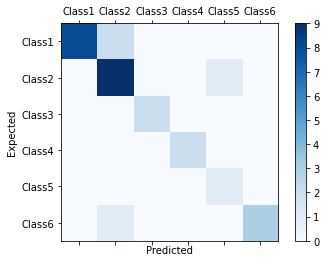


Best Score:  0.7635467980295567 
 
Balanced Score:  0.9083333333333333 
 
Precision Score:  0.875 
 
Recall Score:  0.9083333333333333 
 
F1 Score:  0.8718133718133717 
 
Best Parameters:  {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 1000}

 Scenario 2 - Without low and negative correlation features
Confusion matrix:
 [[10  0  0  0  0  0]
 [ 1  7  0  0  1  1]
 [ 2  0  0  0  0  0]
 [ 0  0  0  2  0  0]
 [ 0  0  0  0  1  0]
 [ 0  1  0  0  0  3]]



Best Score:  0.7275246305418719 
 
Balanced Score:  0.7416666666666667 
 
Precision Score:  0.6490384615384616 
 
Recall Score:  0.7416666666666667 
 
F1 Score:  0.6773349436392916 
 
Best Parameters:  {'class_weight': None, 'max_depth': 10, 'n_estimators': 1000}

 Scenario 3 - Without many zero value features


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:
 [[9 1 0 0 0 0]
 [1 8 0 0 1 0]
 [0 0 2 0 0 0]
 [0 0 0 2 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 3]]



Best Score:  0.7373768472906403 
 
Balanced Score:  0.7416666666666667 
 
Precision Score:  0.7416666666666667 
 
Recall Score:  0.7416666666666667 
 
F1 Score:  0.7416666666666667 
 
Best Parameters:  {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100}

 Scenario 4 - Resembled and balanced target classes
Confusion matrix:
 [[4 1 1 0 0 0]
 [0 6 0 0 0 0]
 [0 0 6 0 0 0]
 [0 0 0 6 0 0]
 [0 0 0 0 6 0]
 [0 0 0 1 0 5]]



Best Score:  0.8680555555555555 
 
Balanced Score:  0.9166666666666665 
 
Precision Score:  0.9285714285714285 
 
Recall Score:  0.9166666666666665 
 
F1 Score:  0.913053613053613 
 
Best Parameters:  {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 1000}


In [44]:
# Tuning n_estimations, max_depth, class_weight:
param_grid_rf = [
    {"n_estimators": [10**i for i in range(1, 4)],
     "max_depth": [i for i in range(5, 26, 5)],
     "class_weight": ["balanced", None]
     }]

gs = GridSearchCV(estimator=RandomForestClassifier(random_state=1,
                                                   n_jobs=-1), 
                  param_grid=param_grid_rf,
                  scoring="accuracy",
                  cv=4,
                  n_jobs=-1
                  )

evaluate(df_scenarios, clf=gs)

**Conclusions**: 
- **In Scenario 1 where the dataset had not feature selection**: 
-- **Confulsion Matrix:** Not ideal, because there are predictions on False Positive and False Negative squares;
-- **Best Score:**  0.7635467980295567 
-- **Balanced Score:**  0.9083333333333333 
-- **Precision Score:**  0.875 
-- **Recall Score:**  0.9083333333333333 
-- **F1 Score:**  0.8718133718133717 
-- **Best Parameters:**  {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 1000}

- **In Scenario 2 where the dataset had feature selection (Without low and negative correlation features)**: 
-- **Confulsion Matrix:** Not ideal, because there are predictions on False Positive and False Negative squares;
-- **Best Score:**  0.7275246305418719 
-- **Balanced Score:**  0.7416666666666667 
-- **Precision Score:**  0.6490384615384616 
-- **Recall Score:**  0.7416666666666667 
-- **F1 Score:**  0.6773349436392916 
-- **Best Parameters:**  {'class_weight': None, 'max_depth': 10, 'n_estimators': 1000}

- **In Scenario 3 where the dataset had feature selection (Without many zero value features)**: 
-- **Confulsion Matrix:** Beter than the previous ones, but still there are predictions on False Positive and False Negative squares;
-- **Best Score:**  0.7373768472906403 
-- **Balanced Score:**  0.7416666666666667 
-- **Precision Score:**  0.7416666666666667 
-- **Recall Score:**  0.7416666666666667 
-- **F1 Score:**  0.7416666666666667 
-- **Best Parameters:**  {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100}

- **In Scenario 4 where the dataset had resembled target classes (Underresembled major classes and oversampled minor classes)**: 
-- **Confulsion Matrix:** The best in this experiment, because there are just a few predictions on False Positive and False Negative squares;
-- **Best Score:**  0.8680555555555555 
-- **Balanced Score:** 0.9166666666666665 
-- **Precision Score:**  0.9285714285714285 
-- **Recall Score:**  0.9166666666666665 
-- **F1 Score:**  0.913053613053613 
-- **Best Parameters:**  {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 1000}

# =======================================================================
# Best models on kaggle:
# =======================================================================

In [0]:
# Research 3, scenario 4:
rf = RandomForestClassifier(n_estimators=1000,
                            max_depth=10,
                            class_weight="balanced",
                            n_jobs=-1,
                            random_state=100)
rf.fit(df4.iloc[:, :-1].values, df4.iloc[:, -1].values)
save_csv(df_test, rf, "compulsory_assignments/CA04/research3_scenario4.csv")
# 0.68571 on kaggle

# Research 3, scenario 3:
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=10,
                            class_weight="balanced",
                            n_jobs=-1,
                            random_state=100)
rf.fit(df3.iloc[:, :-1].values, df3.iloc[:, -1].values)
df_test_sn3 = df_test.drop(["Fe", "Ba"], axis=1)
save_csv(df_test_sn3, rf,
         "compulsory_assignments/CA04/research3_scenario3.csv")
# 0.74285 on kaggle

# Research 3, scenario 2:
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=10,
                            class_weight="balanced",
                            n_jobs=-1,
                            random_state=100)
rf.fit(df2.iloc[:, :-1].values, df2.iloc[:, -1].values)
df_test_sn2 = df_test.drop(["RI", "Fe", "Ca"], axis=1)
save_csv(df_test_sn2, rf,
         "compulsory_assignments/CA04/research3_scenario2.csv")
# 0.77142 on kaggle

# Research 2, scenario 4:
svm = make_pipeline(
    KernelPCA(n_components=5,
              gamma=1,
              kernel="rbf"),
    SVC(C=45,
        gamma=1.525,
        kernel='rbf',
        class_weight="balanced",
        random_state=100))

svm.fit(df4.iloc[:, :-1].values, df4.iloc[:, -1].values)
save_csv(df_test, svm, "compulsory_assignments/CA04/research2_scenario4.csv")
# 0.600 on kaggle

# Research 2, scenario 3:
svm = make_pipeline(
    KernelPCA(n_components=7,
              gamma=1,
              kernel="rbf"),
    SVC(C=10,
        gamma=1.525,
        kernel='rbf',
        class_weight=None,
        random_state=100))

svm.fit(df3.iloc[:, :-1].values, df3.iloc[:, -1].values)
df_test_sn3 = df_test.drop(["Fe", "Ba"], axis=1)
save_csv(df_test_sn3, svm,
         "compulsory_assignments/CA04/research2_scenario3.csv")

# 0.65714 on kaggle


# Research 2, scenario 2:
svm = make_pipeline(
    KernelPCA(n_components=7,
              gamma=1,
              kernel="rbf"),
    SVC(C=115,
        gamma=0.1,
        kernel='rbf',
        class_weight=None,
        random_state=100))

svm.fit(df2.iloc[:, :-1].values, df2.iloc[:, -1].values)
df_test_sn2 = df_test.drop(["RI", "Fe", "Ca"], axis=1)
save_csv(df_test_sn2, svm,
         "compulsory_assignments/CA04/research2_scenario2.csv")

# 0.65714 on kaggle

# Research 1, scenario 4:
svm = make_pipeline(
    SVC(C=100,
        gamma=1,
        kernel='rbf',
        class_weight="balanced",
        random_state=1))

svm.fit(df4.iloc[:, :-1].values, df4.iloc[:, -1].values)
save_csv(df_test, svm, "compulsory_assignments/CA04/research1_scenario4.csv")
# 0.68571 on kaggle

# Research 2, scenario 3:
svm = make_pipeline(
    SVC(C=10,
        gamma=1,
        kernel='rbf',
        class_weight=None,
        random_state=1))

svm.fit(df3.iloc[:, :-1].values, df3.iloc[:, -1].values)
df_test_sn3 = df_test.drop(["Fe", "Ba"], axis=1)
save_csv(df_test_sn3, svm,
         "compulsory_assignments/CA04/research1_scenario3.csv")

# 0.71428 on kaggle


# Research 2, scenario 2:
svm = make_pipeline(
    SVC(C=100,
        gamma=0.1,
        kernel='rbf',
        class_weight=None,
        random_state=100))

svm.fit(df2.iloc[:, :-1].values, df2.iloc[:, -1].values)
df_test_sn2 = df_test.drop(["RI", "Fe", "Ca"], axis=1)
save_csv(df_test_sn2, svm,
         "compulsory_assignments/CA04/research1_scenario2.csv")

# 0.71428 on kaggle

**Conclusion**
- The best model was our research 3 (Random Forest Classifier), scenario 2 (feature selection + parameter tuning) with score **0.77142** on Kaggle.

# =======================================================================
# Final Excercise:
# =======================================================================

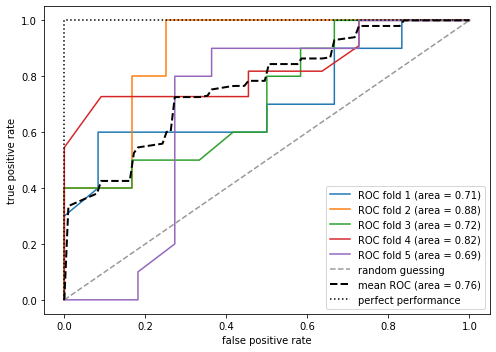

In [47]:
# Create dataframe only with float classes (0) and nonfloat classes (1):
df_float = pd.concat([df[df.type == 1], df[df.type == 3]])
df_float.type = 0
df_nonfloat = pd.concat([df[df.type == 2], df[df.type == 4]])
df_nonfloat.type = 1
df_float_nonfloat = pd.concat([df_float, df_nonfloat])
df_float_nonfloat.index = [i for i in range(1, len(df_float_nonfloat.type)+1)]

# Set up classifier:
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=10,
                            class_weight="balanced",
                            n_jobs=-1,
                            random_state=100)

X = df_float_nonfloat.iloc[:, :-1].values
y = df_float_nonfloat.iloc[:, -1].values

# Cross-validation specification
cv = list(StratifiedKFold(n_splits=5).split(X, y))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# Loop through folds of CV:
for i, (train_idx, test_idx) in enumerate(cv):
    rf.fit(X[train_idx], y[train_idx])
    probas = rf.predict_proba(X[test_idx])

    # False Positive, True Positive and thresholds Rates:
    fpr, tpr, thresholds = roc_curve(y[test_idx],
                                     probas[:, 1],
                                     pos_label=1)

    # Add to mean True Predictive Rate in a smoothed variant (interpolated)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i + 1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

# Average True Positive Rate
mean_tpr /= len(cv)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0

# Average AUC
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

**Conclusion:** The Random Forest Model with 5-fold Cross Validation performed very good, because almost all the lines, included its average, are above the random guessing. This means that the model is better than a simple random guessing. 